In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import signal
from scipy.stats import ttest_ind
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    roc_auc_score,
    roc_curve,
    precision_recall_fscore_support,
)
from sklearn.linear_model import LogisticRegression
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
import tensorflow as tf

In [ ]:
def import_data(file):
    data = []
    df = pd.read_csv(file)
    data.append(df)
    return pd.concat(data)

In [ ]:
def preprocess_data(data):
    b_high, a_high = signal.butter(4, 0.5, 'high', analog=False)
    if len(data) <= 8001:
        return data
    else:
        data[:, 1] = np.pad(data[:, 1], (0, len(b_high) + len(a_high)-2), mode='constant')
        data[:, 1] = signal.filtfilt(b_high, a_high, data[:, 1], axis=0)[len(b_high)-1:len(data[:, 1])-len(a_high)+1]
        b_low, a_low = signal.butter(4, 35, 'low', analog=False)
        data[:, 1] = signal.filtfilt(b_low, a_low, data[:, 1], axis=0)
        return data

In [ ]:
def split_data(data, labels):
    X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)
    X_train = X_train.reshape(X_train.shape[0], X_train.shape[1])
    X_test = X_test.reshape(X_test.shape[0], X_test.shape[1])
    X_val = X_val.reshape(X_val.shape[0], X_val.shape[1])
    return X_train, X_test, X_val, y_train, y_test, y_val

In [ ]:
def display_confusion_matrix(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"Confusion Matrix - {model_name}")
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

In [ ]:
def display_classification_report(y_true, y_pred, model_name):
    report = classification_report(y_true, y_pred, output_dict=True)
    df_report = pd.DataFrame(report).round(2)
    print(f"Classification Report - {model_name}:\n", df_report)

In [ ]:
def display_heatmaps(report, model_name):
    precision_recall = np.array([report['0']['precision'], report['1']['precision'], report['0']['recall'], report['1']['recall']])
    accuracy_macro_avg_weighted_avg = np.array([report['accuracy'], report['macro avg']['precision'], report['macro avg']['recall'], report['macro avg']['f1-score'], report['weighted avg']['precision'], report['weighted avg']['recall'], report['weighted avg']['f1-score']])

    fig, axes = plt.subplots(1, 2, figsize=(15, 6))

    sns.heatmap(precision_recall.reshape(2, 2), annot=True, cmap="Blues", xticklabels=["Precision 0", "Precision 1", "Recall 0", "Recall 1"], yticklabels=["Actual 0", "Actual 1"], fmt=".2f", ax=axes[0])
    axes[0].set_title(f"Heatmap for Precision and Recall - {model_name}")

    xticklabels = ["Accuracy", "Macro Precision", "Macro Recall", "Macro F1-Score", "Weighted Precision", "Weighted Recall", "Weighted F1-Score"]

    sns.heatmap(accuracy_macro_avg_weighted_avg.reshape(1, -1), annot=True, cmap="Blues", xticklabels=xticklabels, fmt=".2f", ax=axes[1])
    axes[1].set_title(f"Heatmap for Accuracy, Macro Avg, Weighted Avg - {model_name}")

    plt.show()

In [ ]:
def visualize_activation_patterns(model, layer_name, input_data):
    # Get the intermediate layer output
    intermediate_layer_model = tf.keras.models.Model(inputs=model.input, outputs=model.get_layer(layer_name).output)
    activations = intermediate_layer_model.predict(input_data)

    # Ensure activations are 4D
    if activations.ndim == 2:
        # Add dimensions to make it 4D for individual activations
        activations = activations.reshape(activations.shape[0], activations.shape[1], 1, 1)

    # Calculate the number of grid rows and columns
    num_activations = activations.shape[-1]
    num_cols = int(np.ceil(np.sqrt(num_activations)))
    num_rows = int(np.ceil(num_activations / num_cols))

    # Set up the figure
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols * 3, num_rows * 3))
    fig.subplots_adjust(hspace=0.5, wspace=0.5)

    # Ensure axes is an array even if there is only one subplot
    if num_activations == 1:
        axes = np.array([axes])

    # Flatten axes array
    axes_flat = axes.flatten()

    # Plot each activation
    for i in range(num_activations):
        ax = axes_flat[i]
        activation = activations[0, :, :, i].squeeze()
        if activation.ndim == 1:
            activation = activation.reshape(int(np.sqrt(activation.shape[0])), -1)
        im = ax.imshow(activation, cmap='viridis', interpolation='nearest', aspect='auto')
        ax.set_title(f'Activation {i + 1}')
        ax.axis('off')

    # Hide any unused axes
    for i in range(num_activations, len(axes_flat)):
        axes_flat[i].axis('off')

    # Add color bar
    fig.colorbar(im, ax=axes.ravel().tolist(), shrink=0.95)
    plt.show()


In [ ]:
def classify_neurological_disorder(X_train, y_train, X_test, y_test):
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    logistic_regression = LogisticRegression()
    logistic_regression.fit(X_train, y_train)
    y_pred = logistic_regression.predict(X_test)
    report = classification_report(y_test, y_pred, output_dict=True)

    display_confusion_matrix(y_test, y_pred, "Neurological Disorder Logistic Regression")
    display_classification_report(y_test, y_pred, "Neurological Disorder Logistic Regression")
    display_heatmaps(report, "Neurological Disorder Logistic Regression")

In [ ]:
def perform_t_test(y_true, y_pred_probs):
    # Calculate the t-statistic and the p-value
    t_stat, p_val = ttest_ind(y_pred_probs, y_true)
    print(f"T-test result: t-statistic={t_stat:.2f}, p-value={p_val:.3f}")

    # Plot the histogram of predicted probabilities and actual labels
    plt.figure(figsize=(10, 6))
    sns.histplot(y_pred_probs, color="blue", label="Predicted Probabilities", kde=False)
    sns.histplot(y_true, color="red", label="Actual Labels", kde=False, bins=[-0.5, 0.5, 1.5])

    # Plot the means of both distributions
    plt.axvline(np.mean(y_pred_probs), color="blue", linestyle='--')
    plt.axvline(np.mean(y_true), color="red", linestyle='--')

    # Annotate the t-statistic and p-value in the plot
    plt.text(0.5, max(plt.ylim()), f't-statistic={t_stat:.2f}', ha='center', va='bottom', color="blue")
    plt.text(0.5, max(plt.ylim()), f'p-value={p_val:.3f}', ha='center', va='top', color="red")

    # Add the legend, title, and show the plot
    plt.legend()
    plt.title('T-test Comparison')
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.show()

In [ ]:
def display_roc_curve(y_true, y_pred_probs, model_name):
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_probs)
    roc_auc = roc_auc_score(y_true, y_pred_probs)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic - {model_name}')
    plt.legend(loc="lower right")
    plt.show()

In [ ]:
def classify_FND_nn(X_train, y_train, X_test, y_test, X_val, y_val):
    model = Sequential()
    model.add(Dense(64, activation='relu', input_shape=(X_train.shape[1],)))
    model.add(Dense(64, activation='relu'))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val), verbose=0)

    y_pred_probs = model.predict(X_test).squeeze()  # Predicted probabilities
    y_pred_nn = (y_pred_probs > 0.5).astype(int)    # Binary predictions
    y_test_nn = y_test.astype(int)

    # Perform and display the t-test
    print("Performing t-test between actual labels and predicted probabilities...")
    perform_t_test(y_test_nn, y_pred_probs)

    # Perform and display the ROC curve analysis
    print("Displaying ROC curve...")
    display_roc_curve(y_test_nn, y_pred_probs, "FND Neural Network")


    report = classification_report(y_test_nn, y_pred_nn, output_dict=True)

    display_confusion_matrix(y_test_nn, y_pred_nn, "FND Neural Network")
    display_classification_report(y_test_nn, y_pred_nn, "FND Neural Network")
    display_heatmaps(report, "FND Neural Network")

    # Visualize activation patterns for the first hidden layer
    visualize_activation_patterns(model, 'dense_6', X_test)

    return y_test_nn, y_pred_nn

In [ ]:
def FND_diagnosis_statement(y_test, y_pred_proba):
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    diagnosis = "The patient is diagnosed with FND." if roc_auc >= 0.7 else "The patient is not diagnosed with FND."
    return diagnosis, roc_auc

Classifying neurological disorder:


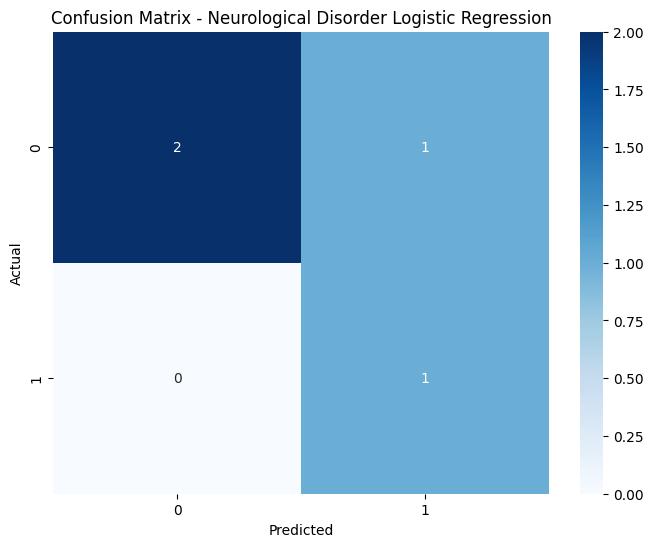

Classification Report - Neurological Disorder Logistic Regression:
               0     1  accuracy  macro avg  weighted avg
precision  1.00  0.50      0.75       0.75          0.88
recall     0.67  1.00      0.75       0.83          0.75
f1-score   0.80  0.67      0.75       0.73          0.77
support    3.00  1.00      0.75       4.00          4.00


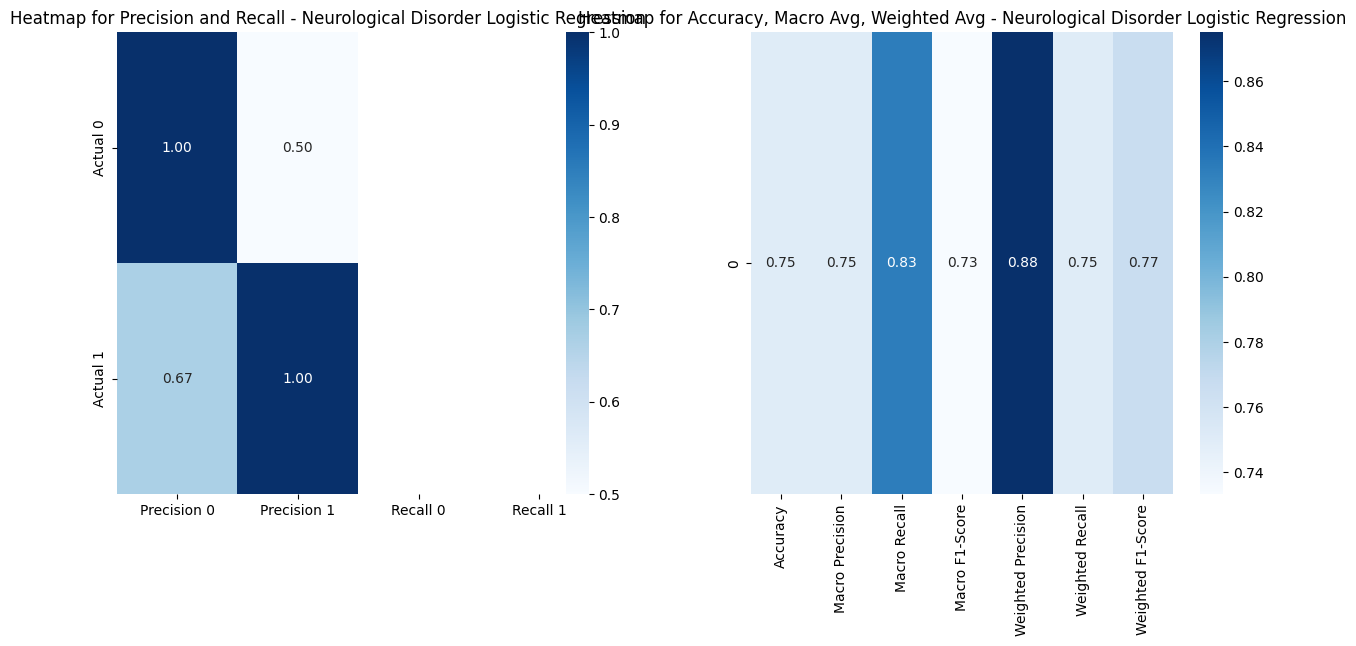

Classifying FND with Neural Network:
1/1 [==============================] - 0s 57ms/step
Performing t-test between actual labels and predicted probabilities...
T-test result: t-statistic=3.00, p-value=0.024


/usr/local/lib/python3.10/dist-packages/scipy/stats/_axis_nan_policy.py:523: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


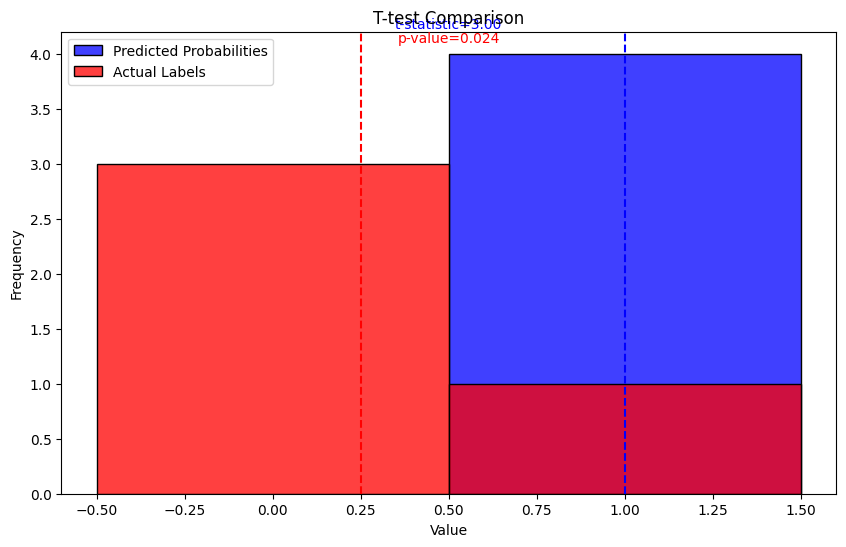

Displaying ROC curve...


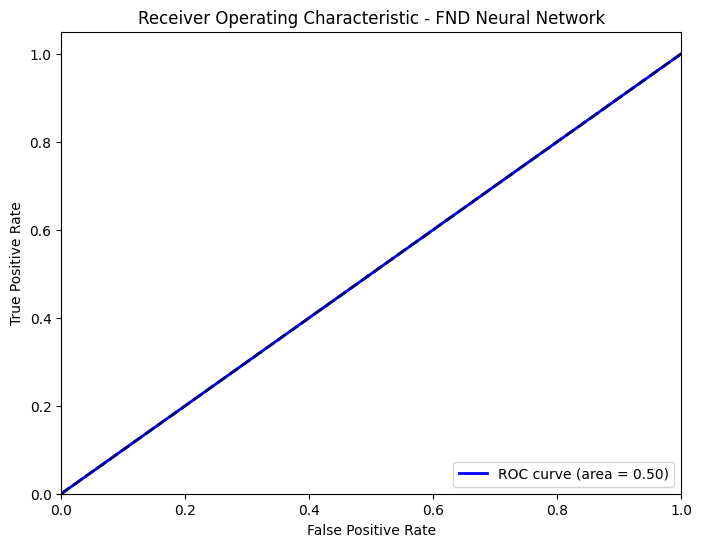

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


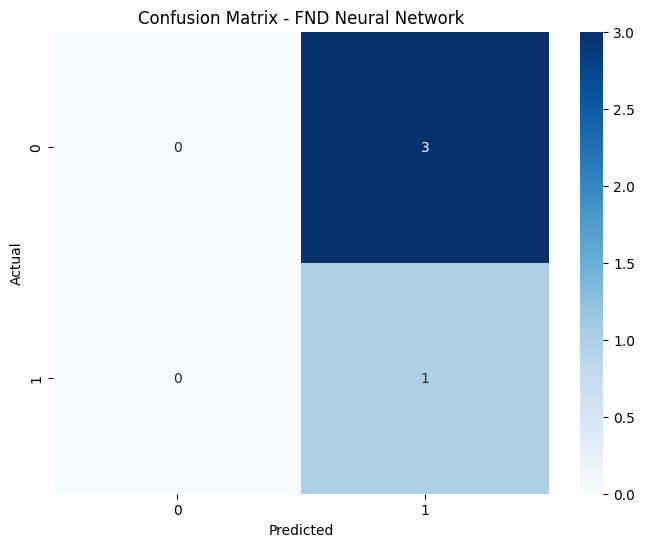

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification Report - FND Neural Network:
              0     1  accuracy  macro avg  weighted avg
precision  0.0  0.25      0.25       0.12          0.06
recall     0.0  1.00      0.25       0.50          0.25
f1-score   0.0  0.40      0.25       0.20          0.10
support    3.0  1.00      0.25       4.00          4.00


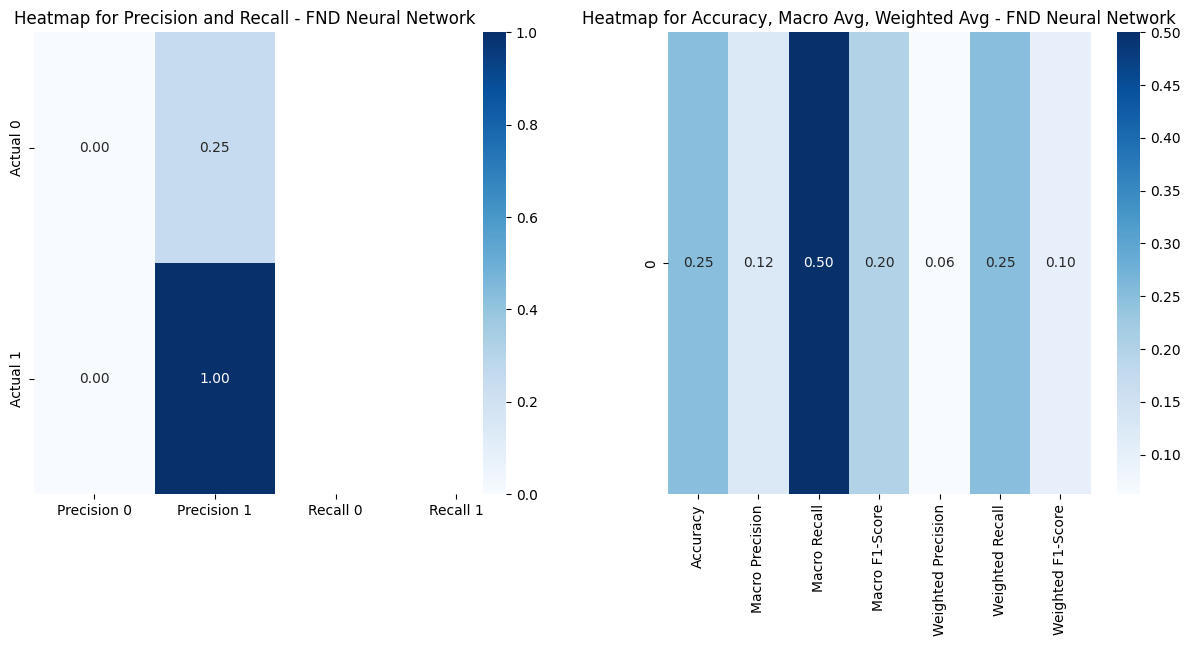

1/1 [==============================] - 0s 40ms/step


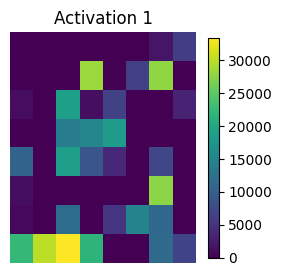


Diagnostic Statement:
The patient is not diagnosed with FND.
ROC AUC: 0.50


In [ ]:
def main():
    file_path = "FNDdata.csv"
    data = import_data(file_path)
    data = preprocess_data(data)
    labels = np.array([0 if i < len(data) / 2 else 1 for i in range(len(data))])
    data_np = data.to_numpy()
    X_train, X_test, X_val, y_train, y_test, y_val = split_data(data_np, labels)

    print("Classifying neurological disorder:")
    classify_neurological_disorder(X_train, y_train, X_test, y_test)

    print("Classifying FND with Neural Network:")
    y_test_nn, y_pred_nn = classify_FND_nn(X_train, y_train, X_test, y_test, X_val, y_val)

    diagnosis, roc_auc = FND_diagnosis_statement(y_test_nn, y_pred_nn)
    print("\nDiagnostic Statement:")
    print(diagnosis)
    print("ROC AUC: {:.2f}".format(roc_auc))

if __name__ == '__main__':
    main()